<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fluidflow/gaspipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of pressure drop in gas pipelines

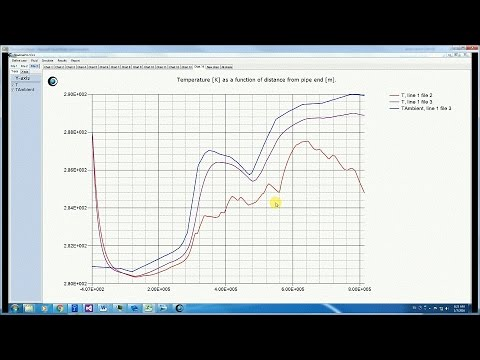

In [7]:
#@title Introduction to Calculation of pressure drop in gas pipelines
#@markdown Calculation of pressure drop in gas pipelines
from IPython.display import YouTubeVideo
YouTubeVideo('C4mq8QlOOsQ', width=600, height=400)

In [8]:
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

In [9]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
fluid1 = fluid("srk")
fluid1.addComponent("CO2", 1.0)
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("methane", 92.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 1.0)
fluid1.setMixingRule(2)

#Creating stream and pipeline
clearProcess()
stream1 = stream(fluid1)
stream1.setFlowRate(20.0, "MSm3/day")
stream1.setTemperature(20.15, "C")
stream1.setPressure(160.0, "bara")

diameter = [0.5, 0.5, 0.5, 1.0, 1.0] #meter
roughnes = [50.0e-6, 50.0e-6, 50.0e-6, 5.0e-6, 5.0e-6] #meter
position = [0.0, 500.0, 1000.0, 2500.0, 200000] #meter
height = [0.0, -400.0, -800.0, -900.0, 0.0] #meter
outtemperatures =[278.15, 278.15, 278.15, 278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0, 25.0, 25.0, 25.0] #W/m2K
wallHeatU = [25.0, 25.0, 25.0, 25.0, 25.0]

pipe1 = pipeline(stream1, position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(10)
runProcess()
print('outlet pressure ', pipe1.getOutStream().getPressure('bara'))
print('outlet temperature ', pipe1.getOutStream().getTemperature('C'))

outlet pressure  122.62966380434445
outlet temperature  2.706398150018231


# Graphical output of pressure and temperature profile of pipeline

Text(0.5, 0, 'Length [meter]')

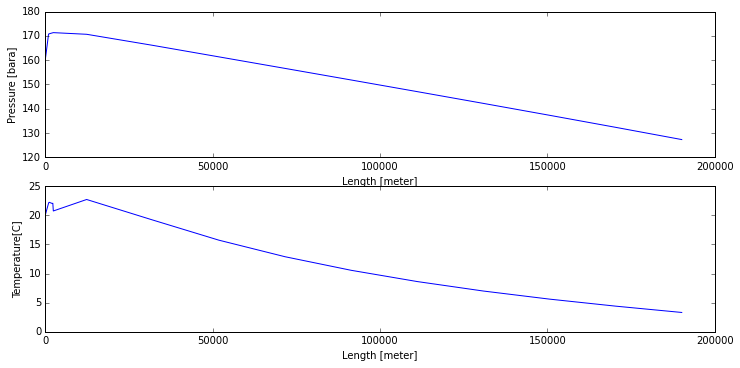

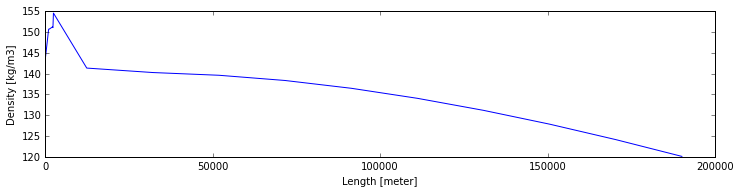

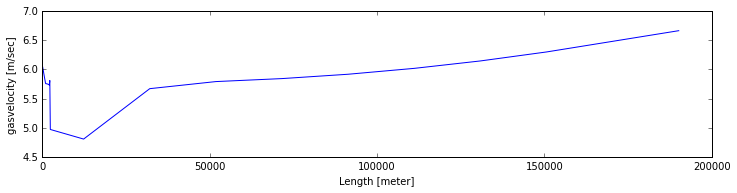

In [11]:
pres = []
temp = []
length = []
height = []
calcdensity = []
gasvelocity = []

for node in range (0,pipe1.getPipe().getTotalNumberOfNodes()-1):
  pres.append(pipe1.getPipe().getNode(node).getBulkSystem().getPressure('bara'))
  temp.append(pipe1.getPipe().getNode(node).getBulkSystem().getTemperature('C'))
  height.append(pipe1.getPipe().getNode(node).getVerticalPositionOfNode())
  length.append(pipe1.getPipe().getNode(node).getDistanceToCenterOfNode())
  calcdensity.append(pipe1.getPipe().getNode(node).getBulkSystem().getDensity('kg/m3'))
  gasvelocity.append(pipe1.getPipe().getNode(node).getVelocity()) 

plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(4, 1, 1)
plt.plot(length, pres, '-')
plt.ylabel('Pressure [bara]')
plt.xlabel('Length [meter]')

plt.subplot(4, 1, 2)
plt.plot(length, temp)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature[C]')

plt.figure()
plt.subplot(4, 1, 3)
plt.plot(length, calcdensity, '-')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(4, 1, 4)
plt.plot(length, gasvelocity, '-')
plt.ylabel('gasvelocity [m/sec]')
plt.xlabel('Length [meter]')